# Astrobee Example

### Script / GuSTO Initialization

In [4]:
# Initializing script
include("astrobee_se3_script.jl")

# Number of time-discretization points and maximum number of GuSTO iterations
N, max_it = 30, 100

# Defining the model, the initial strategy and each convex subproblem
model      = AstrobeeSE3()
Xp,Up      = initialize_trajectory(model,N)
SCPproblem = GuSTOProblem(model,N,Xp,Up)

# Defining GuSTO parameters
(Delta0, omega0, omegamax, epsilon, rho0,
        rho1, beta_succ, beta_fail, gamma_fail, 
        convergence_threshold) = get_initial_gusto_parameters(model)

(100.0, 1.0, 1.0e9, 0.001, 10.0, 20.0, 2.0, 0.5, 5.0, 2.5)

### GuSTO Algorithm

In [5]:
# Defining penalization weights, trust-region radius and the list of solutions
Xp,Up        = initialize_trajectory(model,N)
X, U         = copy(Xp), copy(Up)
omega, Delta = omega0, Delta0
X_all, U_all = [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

# GuSTO loop
success, it = false, 1
while it < max_it                                                               && 
      !(success && convergence_metric(model,X,U,Xp,Up) < convergence_threshold) &&
      omega < omegamax
    println("-----------\nIteration $it\n-----------")
    
    # Storing the solution at the previous step and the linearized dynamics
    Xp, Up                    = copy(X), copy(U)
    model.f, model.A, model.B = compute_dynamics(model,Xp,Up)
    
    # Defining the convex subproblem
    reset_problem(     SCPproblem, model)
    set_parameters(    SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(       SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    # Solving the convex subproblem
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol, U_sol = JuMP.value.(SCPproblem.X), JuMP.value.(SCPproblem.U)
    
    # -----------
    # GuSTO Logic
    
    # Trust-region constraints are satisfied
    if is_in_trust_region(model,X_sol,U_sol,Xp,Up,Delta)
        
        # Computing accuracy ratio rho
        rho = accuracy_ratio(SCPproblem,model,X_sol,U_sol,Xp,Up)

        # Too coarse linearization: reject solution
        if rho > rho1
            println("Reject solution (the linearization is too coarse).")
            Delta, omega = beta_fail*Delta, omega
            success      = false
        
        # Accepting solution
        else
            println("Accept solution.")
            X, U    = copy(X_sol), copy(U_sol)
            success = true
            
            # Check precision of linearization
            if rho < rho0
                Delta = min(beta_succ*Delta,Delta0) # Optimal / Precise 
            else
                Delta = Delta                       # Imprecise - bad
            end
            
            # Check satisfaction of state constraints
            if satisfies_state_inequality_constraints(SCPproblem,model,X_sol,U_sol,Xp,Up,Delta)
                omega = omega0 # All constraints are satisfied - good
            else
                # State constraints are not satisfied: increase penalization weights
                println("Solution does not satisfy state constraints, increasing omega.")
                omega   = gamma_fail*omega
                success = false
            end
        end
        
    # Trust-region constraints are NOT satisfied
    else
        println("Reject solution (the trust region constraints are not satisfied).")
        Delta   = Delta
        omega   = gamma_fail*omega
        success = false
    end

    # Collecting the solution at each iteration
    push!(X_all,copy(X))
    push!(U_all,copy(U))
    it += 1
    
    println("Parameters:")
#     println("omega  = $omega")
#     println("delta  = $Delta")
    println("metric = $(convergence_metric(model,X,U,Xp,Up))")
#     println(" ")
end


-----------
Iteration 1
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Accept solution.
Parameters:
metric = 34.61459858442126
-----------
Iteration 2
-----------
Accept solution.
Parameters:
metric = 22.924395175849813
-----------
Iteration 3
-----------
Accept solution.
Parameters:
metric = 3.65770454675172
-----------
Iteration 4
-----------
Accept solution.
Parameters:
metric = 0.7383809659968572


### Plotting the solution

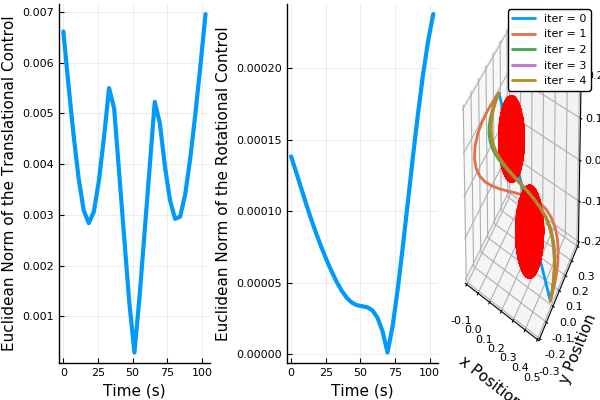

In [7]:
# NOTE: run this cell twice

# Collecting the final control
timeSpan = zeros(N)
timeSpanControl = zeros(N-1)
constraint = zeros(N)
constraint[1] = obstacle_constraint(model,X_all[end],U_all[end],X_all[end-1],U_all[end-1],1,1)
control1 = zeros(N-1)
control2 = zeros(N-1)
for i = 1:N-1
    timeSpan[i+1] = timeSpan[i] + model.tf/N
    if i < N-1
        timeSpanControl[i+1] = timeSpan[i] + model.tf/N
    end
    constraint[i+1] = obstacle_constraint(model,X_all[end],U_all[end],X_all[end-1],U_all[end-1],i,1)
    control1[i] = norm(U_all[end][1:3,i])
    control2[i] = norm(U_all[end][4:6,i])
end

# Plotting the final control
p1 = plot(timeSpanControl,control1,linewidth=3,label="",xlabel="Time (s)",ylabel="Euclidean Norm of the Translational Control")
p2 = plot(timeSpanControl,control2,linewidth=3,label="",xlabel="Time (s)",ylabel="Euclidean Norm of the Rotational Control")

# Plotting the trajectory at different SCP iterations
p3 = plot3D_solutions(SCPproblem, model, X_all[1:end], U_all[1:end])

plot(p1,p2,p3,layout=(1,3))